# SIMULATION OF SELECTION BIAS

In [253]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import pickle
from scipy.special import expit

In [415]:
from model_class import CatBoostXT_BAG

In [252]:
from other_utils import compare_distributions

In [1]:
data_dir = r'E:\Project\Dissertation'

In [2]:
list_key = ['SK_ID_CURR']
label_col = 'TARGET'

In [8]:
df = pd.read_parquet(rf'{data_dir}\data\processed\master_data_flagged_trainval.parquet')

In [9]:
# separate features, target
list_features = [col for col in df.columns if col not in ['TARGET','SK_ID_CURR','flag_train_val']]
# features that starts with EXT_
list_ext_features = [col for col in df.columns if col.startswith('EXT_')]
# list ethical features
list_ethical_features = [col for col in df.columns if 'GENDER' in col]
# list categorical features
list_cat_features = df.select_dtypes(include=['object','category']).columns.tolist()
list_cat_features = list(set(list_cat_features)-set(list_ethical_features)-set(['flag_train_val']))

In [10]:
df[list_cat_features] = df[list_cat_features].fillna('Missing')

In [51]:
df_bureau  = pd.read_csv(rf'{data_dir}\home-credit-default-risk\bureau.csv')

In [52]:
df['flag_has_bureau'] = np.where(df['SK_ID_CURR'].isin(df_bureau['SK_ID_CURR']),1,0)

## Simulate credit policies

Simulate selection bias and missing types by simulating credit policies:

Missing Not At a Random (MNAR):  ommitted from both oracle model and all subsequent models of the research --> drive approval process but not existed in training
- Exteral scoring EXT_MEAN: <20 --> reject, >80 --> good customers that cannot accquire due to competition -- stochastic 
- Customer with no bureau ever before: can be approximate using missing value of bureau features -- deterministic

Missing At a Random (MAR): drive approval process and used for training
- AGE_YEARS: >= 30, <= 60 -- stochastic 
- CREDIT_TO_INCOME: >4 -- stochastic 
- No defaut status > 1 (>60DPD in the last 12 months) -- deterministic




### Check distribution

In [434]:
df[['FLAG_OWN_CAR']].value_counts()

FLAG_OWN_CAR
N               202924
Y               104587
Name: count, dtype: int64

In [20]:
df[['EXT_MEAN']].describe()

,EXT_MEAN
count,307339.000000
mean,0.509251
std,0.149802
min,0.000006
25%,0.413648
50%,0.524502
75%,0.622819
max,0.878903


In [21]:
df[['AGE_YEARS']].describe()

,AGE_YEARS
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


In [22]:
df[['CREDIT_TO_INCOME']].describe()

,CREDIT_TO_INCOME
count,307511.000000
mean,3.957570
std,2.689728
min,0.004808
25%,2.018667
50%,3.265067
75%,5.159880
max,84.736842


In [43]:
df[['bb_w12_status_max__max']].value_counts()

bb_w12_status_max__max
0.0                       57661
1.0                       12914
5.0                         962
2.0                         897
3.0                         201
4.0                         137
Name: count, dtype: int64

In [54]:
df[['flag_has_bureau']].value_counts()

flag_has_bureau
1                  263491
0                   44020
Name: count, dtype: int64

### Create policies

#### Deterministic policies

In [368]:
def approval_policies_deterministic():
    approval_mask = (
        (df['bb_w12_status_max__max'].fillna(0) <= 1) &
        (df['flag_has_bureau'].fillna(0) == 1)
    )
    return approval_mask

In [369]:
mask_deterministic_approval = approval_policies_deterministic()

In [370]:
mask_deterministic_approval

0         False
1          True
2          True
3          True
4          True
          ...  
307506     True
307507     True
307508     True
307509     True
307510     True
Length: 307511, dtype: bool

In [371]:
mask_deterministic_approval.value_counts()

True     261294
False     46217
Name: count, dtype: int64

#### Probabilistic Policy Override

In [462]:
def probabilistic_override_model(deterministic_mask, threshold=0.05, random_state=1):
    soft_approval = (
        (df['EXT_MEAN'].fillna(0).between(0.5,0.8)) &
        (df['AGE_YEARS'].fillna(40).between(30,50)) &
        (df['CREDIT_TO_INCOME'].fillna(1).between(0,3))
    )
    
    np.random.seed(random_state)
    # take 5% of the rejected applications, return the index
    override_mask = (np.random.uniform(0,1,len(soft_approval)) < threshold)


    return deterministic_mask & (soft_approval | override_mask)

In [463]:
mask_final_approval = probabilistic_override_model(mask_deterministic_approval,threshold=0.05)

In [464]:
df_simulation = df.loc[mask_final_approval].copy()

In [399]:
df_simulation.to_parquet(rf'{data_dir}\data\processed\master_data_simulated_approval.parquet',index=False)

In [465]:
df_simulation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45730 entries, 2 to 307502
Columns: 590 entries, SK_ID_CURR to flag_has_bureau
dtypes: float64(520), int32(1), int64(47), object(22)
memory usage: 206.0+ MB


### Visualise the impact

##### Credit filter features

In [466]:
df_simulation[['EXT_MEAN']].describe()

,EXT_MEAN
count,45728.000000
mean,0.579405
std,0.105199
min,0.000492
25%,0.528532
50%,0.584866
75%,0.648866
max,0.840821


In [467]:
df_simulation[['AGE_YEARS']].describe()

,AGE_YEARS
count,45730.000000
mean,41.301168
std,8.055693
min,21.134247
25%,35.392466
50%,40.723288
75%,46.155479
max,68.986301


In [468]:
df_simulation[['CREDIT_TO_INCOME']].describe()

,CREDIT_TO_INCOME
count,45730.000000
mean,2.499781
std,1.785552
min,0.066667
25%,1.500000
50%,2.142857
75%,2.812500
max,27.970000


invalid value encountered in multiply


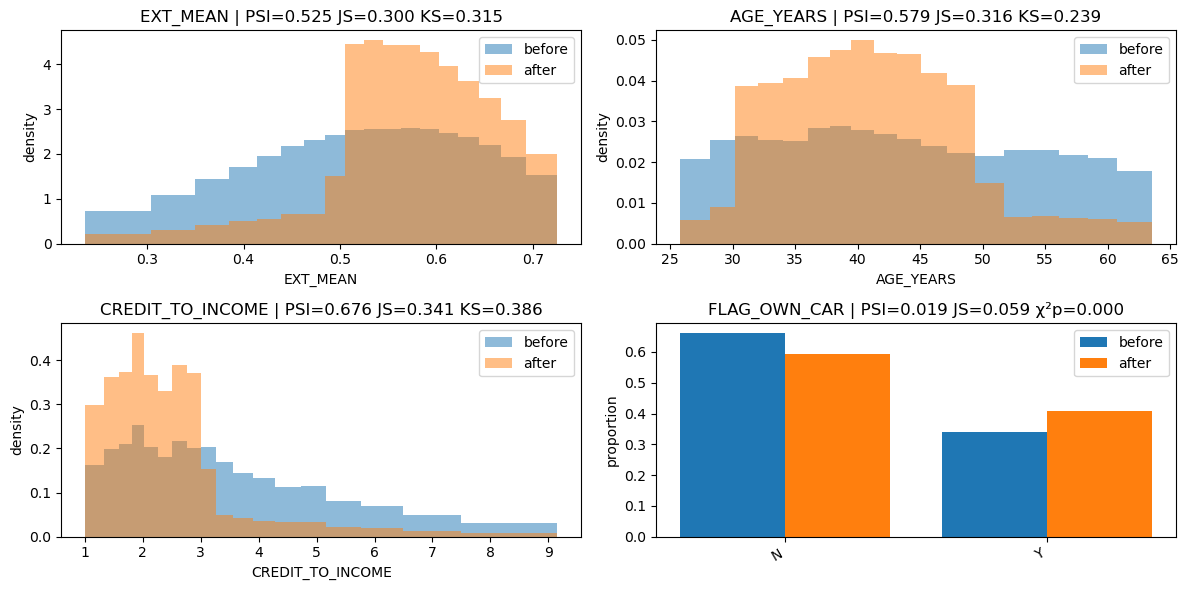

,feature,type,psi,js,ks,chi2_p,n_before,n_after
0,EXT_MEAN,numeric,0.525155,0.300222,0.314811,NaN,307339,45728
1,AGE_YEARS,numeric,0.578965,0.315695,0.239394,NaN,307511,45730
2,CREDIT_TO_INCOME,numeric,0.675538,0.341027,0.386345,NaN,307511,45730
3,FLAG_OWN_CAR,categorical,0.018999,0.058504,NaN,1.383441e-198,307511,45730


In [469]:
compare_distributions(before=df, after=df_simulation, features=['EXT_MEAN','AGE_YEARS','CREDIT_TO_INCOME','FLAG_OWN_CAR'],plot=True)

#### Most important features in oracle model

In [472]:
# load pickle
with open(rf'{data_dir}\models\oracle_model_catboostxt_bag.pkl', 'rb') as f:
    oracle_model = pickle.load(f)

In [473]:
df_oracle_shap_imp = oracle_model.feature_importances_shap_
df_oracle_shap_imp.head(10)

,feature,importance
0,ANNUITY_TO_CREDIT,0.140965
1,GOODS_TO_CREDIT,0.138091
2,NAME_EDUCATION_TYPE,0.110246
3,OCCUPATION_TYPE,0.103849
4,DAYS_BIRTH,0.090873
5,AMT_ANNUITY,0.087380
6,DAYS_EMPLOYED,0.069607
7,AMT_GOODS_PRICE,0.068951
8,w720_utilization_portfolio,0.061753
9,DAYS_LAST_PHONE_CHANGE,0.061040


In [418]:
df[df[oracle_model.cat_features].isnull().any(axis=1)]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bb_w24_status_3_share__max,bb_w24_status_3_share__sum,bb_w24_status_4_share__mean,bb_w24_status_4_share__max,bb_w24_status_4_share__sum,bb_w24_status_5_share__mean,bb_w24_status_5_share__max,bb_w24_status_5_share__sum,flag_train_val,flag_has_bureau


In [ ]:
oracle_model.plot_shap_summary_plot(df[oracle_model.used_features],max_display=10, plot_size=(20,10))

invalid value encountered in multiply
invalid value encountered in multiply


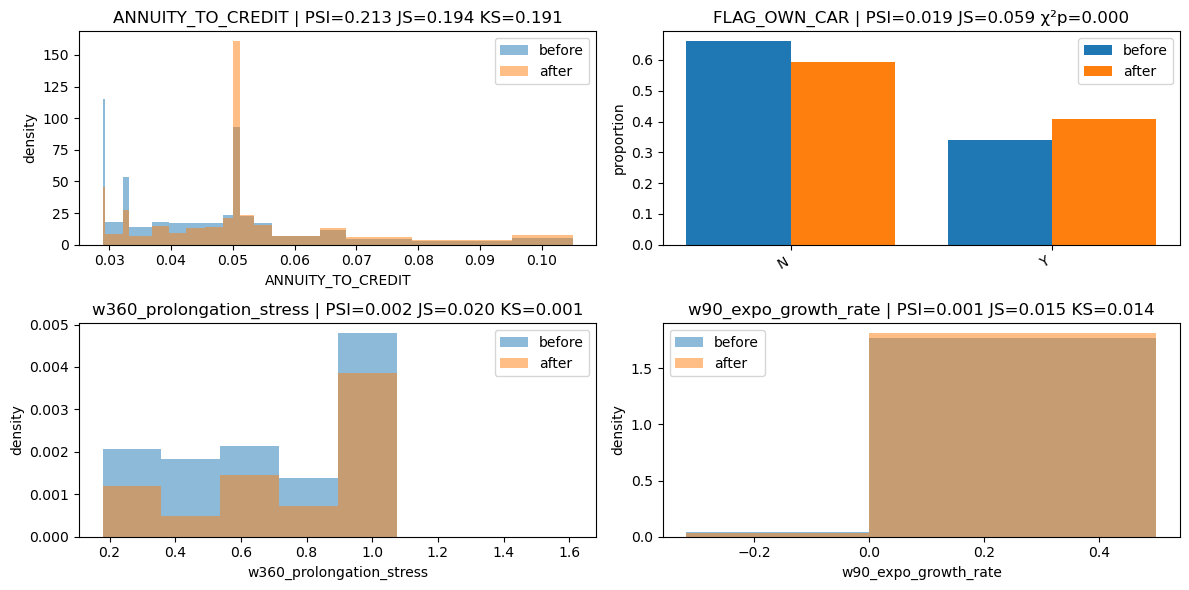

,feature,type,psi,js,ks,chi2_p,n_before,n_after
0,ANNUITY_TO_CREDIT,numeric,0.212576,0.194082,0.191285,NaN,307499,45728
1,FLAG_OWN_CAR,categorical,0.018999,0.058504,NaN,1.383441e-198,307511,45730
2,w360_prolongation_stress,numeric,0.002221,0.019786,0.000890,NaN,149248,23189
3,w90_expo_growth_rate,numeric,0.001236,0.014914,0.014345,NaN,38199,5289


In [471]:
compare_distributions(before=df, after=df_simulation, features=['ANNUITY_TO_CREDIT','FLAG_OWN_CAR','w360_prolongation_stress','w90_expo_growth_rate'],plot=True)